# Step 1 - Preprocess ##

Do the following:

1. Lift subject with SAM2 from rgb image.

2. Clean the points, remove low confidence from Lidar, offset edge from depth_anything_v2

3. Convert to `ProcessedVignette` class

4. Subdivide with DBSCAN

In [1]:
import os
os.environ["SAM_BACKEND"] = "coreml" # coreml or pytorch

import sys
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from pipeline import segmentation, pointcloud

# get the root for importing test data
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

scikit-learn version 1.7.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.5.1. Disabling scikit-learn conversion API.
Torch version 2.8.0 has not been tested with coremltools. You may run into unexpected errors. Torch 2.5.0 is the most recent version that has been tested.


In [2]:
VIGNETTE_NAME = "capture4"
VIGNETTE_PATH = project_root / "test_data" / VIGNETTE_NAME

rgb_path = VIGNETTE_PATH / "rgb.png"
metadata_path = VIGNETTE_PATH / "metadata.json"
results_path = VIGNETTE_PATH / "results"

## 1.1 SAM2 ##

In [4]:
# UV for user tap
uv_coords = [0.5, 0.5]

# Run SAM to get raw logits
logits_path = segmentation.generate_sam_logits(
    rgb_image_path=rgb_path,
    uv_coords=uv_coords,
    output_path=results_path
)
print(f"Logits generated and saved to: {logits_path}")

[sam2] Loading CoreML SAM2 models…
[sam2] Saved CoreML SAM2 logits: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture4/results/mask_logits.npy shape=(4032, 3024)
Logits generated and saved to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture4/results/mask_logits.npy


[sam] Wrote mask: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture4/results/mask.png
Mask created and saved to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture4/results/mask.png


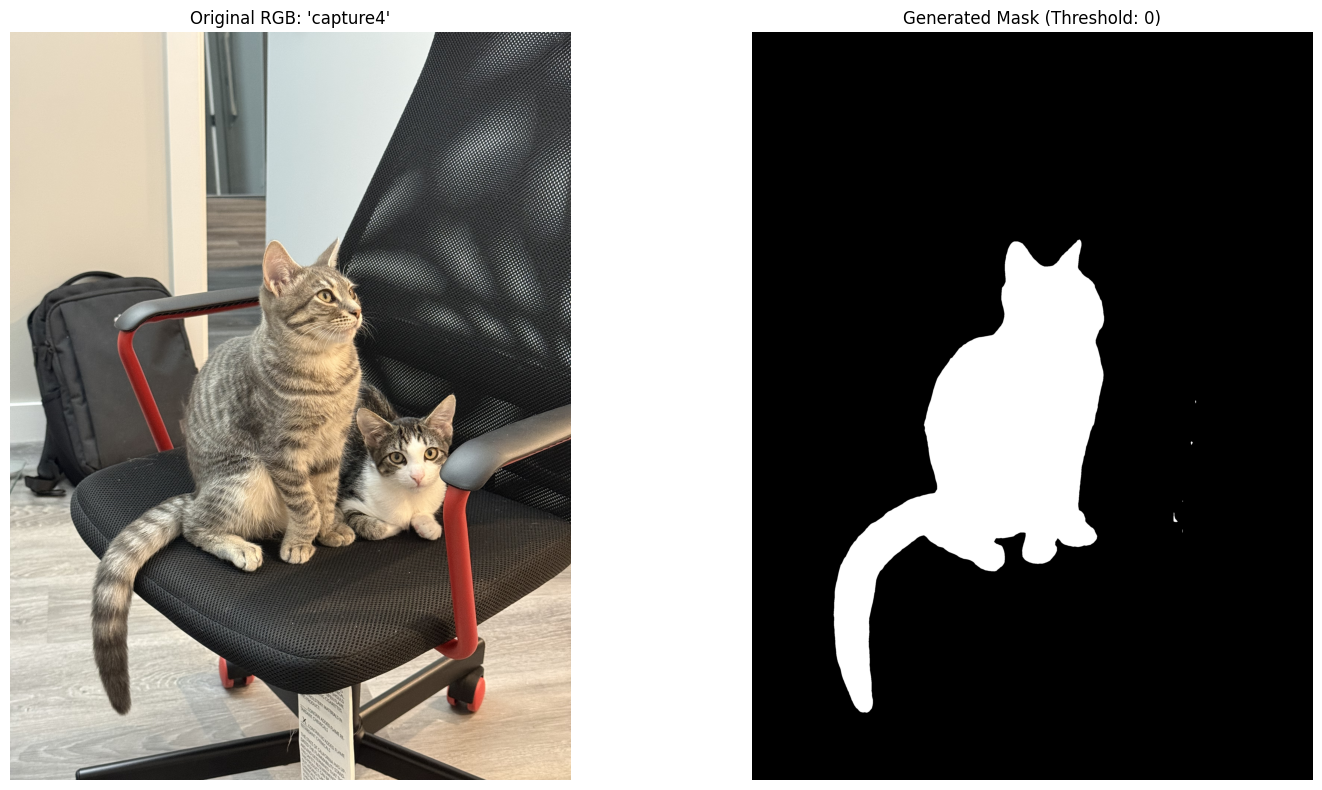

In [5]:
sam_threshold = 0

# Apply the threshold
mask_path = segmentation.apply_threshold_to_logits(
    logits_path=logits_path,
    threshold=sam_threshold,
    output_path=results_path
)
print(f"Mask created and saved to: {mask_path}")

# Display
rgb_image = Image.open(rgb_path)
mask_image = Image.open(mask_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(rgb_image)
axes[0].set_title(f"Original RGB: '{VIGNETTE_NAME}'")
axes[0].axis('off')

axes[1].imshow(mask_image, cmap='gray')
axes[1].set_title(f"Generated Mask (Threshold: {sam_threshold})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 1.2 Convert to Raw ProcessedVignette class ##

In [8]:
# Create a raw point cloud
vignette_path = pointcloud.create_masked_point_cloud(
    VIGNETTE_PATH, 
    stride=12 # Use 1 for lidar capture cause it's already sparse
)

Processing point cloud for: capture4
Generated and centered point cloud with 10005 points.
Saved processed vignette to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture4/results/raw_vignette.npz


In [3]:
vignette_path = results_path / "raw_vignette.npz"
# Load the points as a processed vignette
from pipeline.vignette_data import ProcessedVignette
raw_vignette = ProcessedVignette.load(vignette_path)

Loaded processed vignette from: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture4/results/raw_vignette.npz


Visualize Raw Points

In [6]:
import open3d as o3d

# Open3d display helper
def display_geometries(geometries: list, window_name: str = "Open3D"):
    # Create a Visualizer object
    vis = o3d.visualization.Visualizer()
    # Create the window with a custom name
    vis.create_window(window_name=window_name)
    # Add each geometry to the visualizer
    for geometry in geometries:
        vis.add_geometry(geometry)  
    # Run the visualizer
    vis.run()
    # Destroy it after close
    vis.destroy_window()
    vis.close()
    del vis

In [12]:
# Visualize Colors
pcd_rgb = raw_vignette.to_open3d(color_mode="rgb")
display_geometries([pcd_rgb], window_name="Vignette (RGB Colors)")

Generating Open3D point cloud with 'rgb' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


## 1.3 Cleanup Points ##

- Remove low confidence if available
- Downsample if use_voxel_downsampling
- Remove outlier with SOR (Statistical Outlier Removal)
- Estimate normals
- Save as `results/processed_vignette.npz`

In [4]:
from pipeline import preprocessing

processed_vignette_path = results_path / "processed_vignette.npz"

processed_vignette = preprocessing.preprocess_vignette(
    raw_vignette=raw_vignette,
    confidence_threshold=1, # Confidence threshold for LiDAR depth
    voxel_size=0.001,
    sor_std_ratio=3.0, # Lower gives more aggressive cleanup
    use_voxel_downsampling=False, # Whether to use downsample
    save_path=processed_vignette_path # Auto save
)

--- Starting Preprocessing ---
Initial points: 10005
Info: No 'confidence' attribute found, skipping confidence filtering.
Skipping vocel downsampling...
Points after downsampling: 10005
Removing statistical outliers...
Points after outlier removal: 9964
Estimating normals...
Normals estimated and oriented.
Reconciling custom attributes...
Saved processed vignette to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture4/results/processed_vignette.npz
Saved vignette to /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture4/results/processed_vignette.npz
--- Preprocessing complete. Returning new clean vignette. ---


Generating Open3D point cloud with 'rgb' colors...
Generating Open3D point cloud with 'rgb' colors...


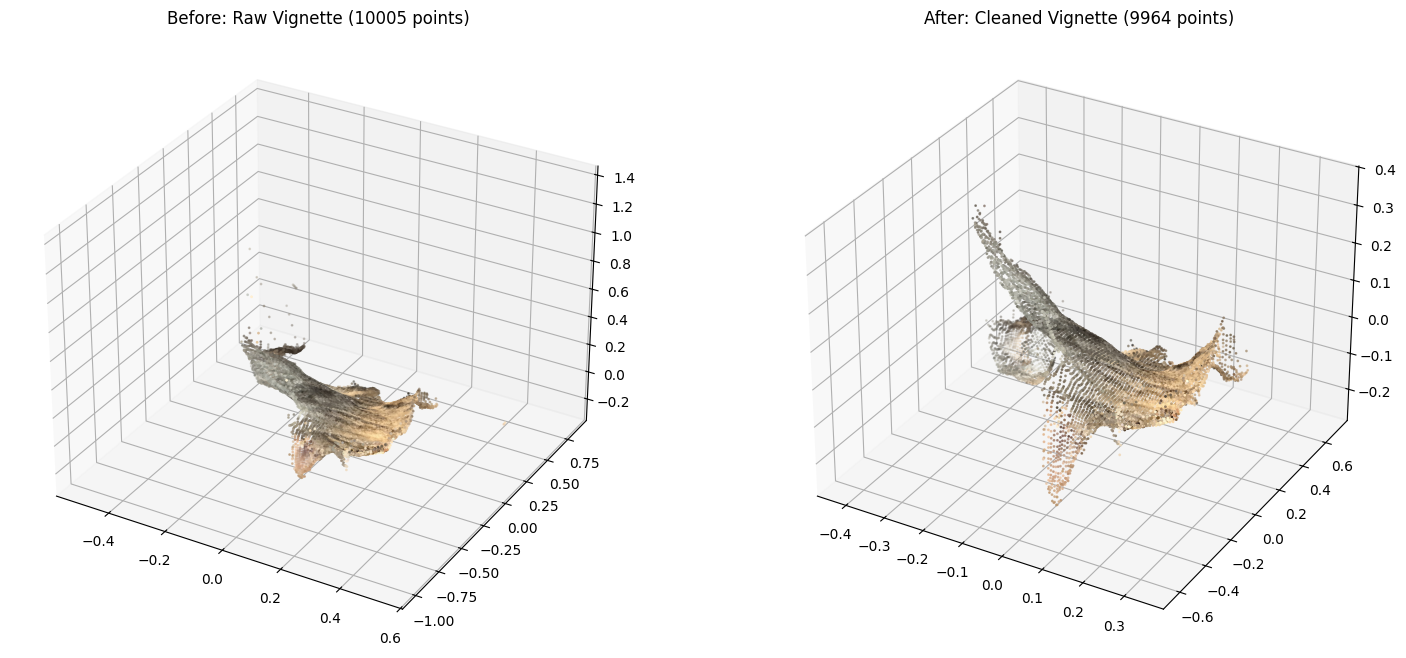

In [5]:
# Compare before and after
import numpy as np
fig = plt.figure(figsize=(18, 8))

# Before
ax1 = fig.add_subplot(121, projection='3d')
pcd_raw_viz = raw_vignette.to_open3d().voxel_down_sample(0.001) # Downsample for viz
ax1.scatter(
    np.asarray(pcd_raw_viz.points)[:, 0], np.asarray(pcd_raw_viz.points)[:, 1], np.asarray(pcd_raw_viz.points)[:, 2],
    c=np.asarray(pcd_raw_viz.colors), s=1
)
ax1.set_title(f"Before: Raw Vignette ({len(raw_vignette.points)} points)")
    
# After
ax2 = fig.add_subplot(122, projection='3d')
pcd_clean_viz = processed_vignette.to_open3d()
ax2.scatter(
    np.asarray(pcd_clean_viz.points)[:, 0], np.asarray(pcd_clean_viz.points)[:, 1], np.asarray(pcd_clean_viz.points)[:, 2],
    c=np.asarray(pcd_clean_viz.colors), s=1
)
ax2.set_title(f"After: Cleaned Vignette ({len(processed_vignette.points)} points)")
    
plt.show()

In [7]:
pcd = processed_vignette.to_open3d()
display_geometries([pcd], window_name="Preprocessed Vignette")

Generating Open3D point cloud with 'rgb' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


## 1.4 DBSCAN ##

This is not so useful in many tests, probably need more tests.

In [4]:
# Load processed vignette if not already
processed_vignette_path = results_path / "processed_vignette.npz"
from pipeline.vignette_data import ProcessedVignette
processed_vignette = ProcessedVignette.load(processed_vignette_path)

Loaded processed vignette from: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture4/results/processed_vignette.npz


In [5]:
from pipeline import preprocessing

# Get suggested eps
cluster_eps = preprocessing.suggest_eps(
    processed_vignette, 
    k=8, 
    percentile=90
)
print(cluster_eps)

0.016724380105975743


In [6]:
# run DBSCAN
preprocessing.identify_components(
    processed_vignette, 
    cluster_eps=cluster_eps, # Neighborhood radius
    min_cluster_points=50,
    auto_save=True
)

Identifying components with eps=0.016724380105975743...
Set/updated per-point attribute: 'component_id'.
Saved processed vignette to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture4/results/processed_vignette.npz
   - Found 0 components and assigned 'component_id' attribute.


0